In [1]:
from car_part import CarPartDataset, CarPartConfig, prepare_datasets, preprocess_dataset
from pathlib import Path
from mrcnn import visualize
import colorsys
import random
import numpy as np
import mrcnn.model as modellib
from mrcnn.model import log
import scipy.io as sio

import matplotlib.pyplot as plt

Using TensorFlow backend.


# How to train the model

In [2]:
part_annotation_files = Path(
    '../../../car-damage-estimation/data/car_part/trainval/Annotations_Part/')
images_path = Path('../../../car-damage-estimation/data/VOCdevkit/VOC2010/JPEGImages/')

images_annotations_files = list(Path(part_annotation_files).glob('*.mat'))

## Prepare the datasets

In [3]:
dataset_train, dataset_val, dataset_test = prepare_datasets(images_path, images_annotations_files, 0.7, 0.8)

100%|██████████| 10103/10103 [02:23<00:00, 70.64it/s]


In [4]:
print(dataset_train.num_images, dataset_val.num_images, dataset_test.num_images)

715 102 205


### Check some images

In [5]:
def draw_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

In [6]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors

In [7]:
colors = random_colors(30)

In [8]:
i = 2

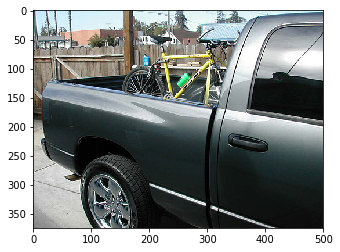

In [9]:
img = dataset_train.load_image(i)
plt.imshow(img)

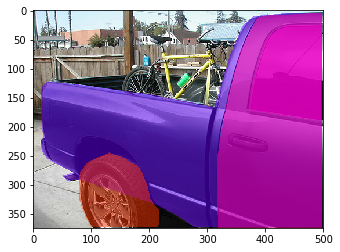

In [10]:
mask, classes = dataset_train.load_mask(i)
img_copy = img.copy()

for l in range(mask.shape[-1]):
    img_copy = draw_mask(img_copy, mask[:,:,l], colors[l])
    
plt.imshow(img_copy)

In [11]:
[dataset_val.class_names[c] for c in classes]

['rightside', 'door_1', 'wheel_1', 'window_1']

## Create the model

In [12]:
import os

In [13]:
config = CarPartConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                43
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [14]:
MODEL_DIR = './logs/'

In [15]:
config.BATCH_SIZE

1

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
model.load_weights(model.get_imagenet_weights(), by_name=True)

In [ ]:
model.train(dataset_val, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=2, 
            layers='heads')

## Inspect the model results

In [16]:
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [17]:
model.find_last()

'./logs/car_parts20190326T1032/mask_rcnn_car_parts_0040.h5'

In [18]:
model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 40


In [19]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

image ID: car_parts.2009_004224.jpg (9) ../../../car-damage-estimation/data/VOCdevkit/VOC2010/JPEGImages/2009_004224.jpg
Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 43)               min:    0.00000  max:  512.00000  int64
anchors                  shape: (1, 65472, 4)         min:   -0.70849  max:    1.58325  float32
gt_class_id              shape: (23,)                 min:    1.00000  max:   22.00000  int64
gt_bbox                  shape: (23, 4)               min:    0.00000  max:  511.00000  int32
gt_mask                  shape: (512, 512, 23)        min:    0.00000  max:    1.00000  bool
CPU times: user 14.2 s, sys: 1.68 s, total: 15.9 s
Wall time: 2.06 s


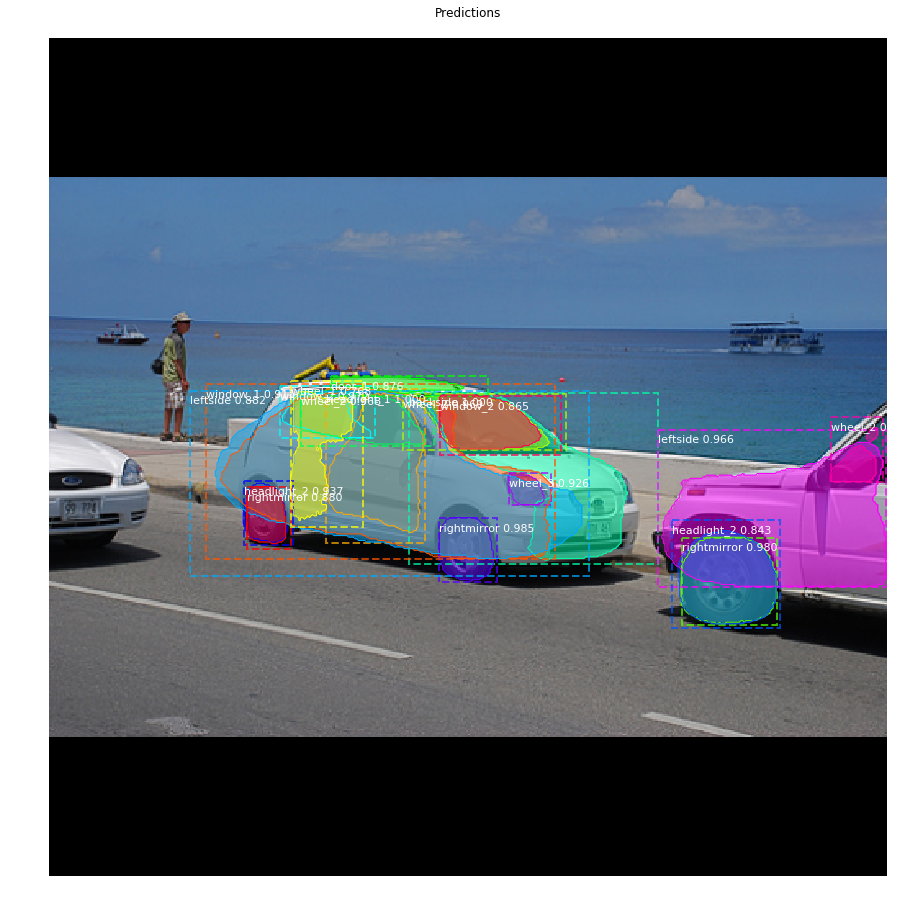

In [21]:
%%time
image_id = 9
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)